In [460]:
!pip install utils

import seaborn as sns
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from torchvision import models
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import math
import numpy as np
import time
from torch import einsum
import cv2
import scipy.misc
import utils
import tqdm
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import timm

In [134]:
from google.colab import drive
import pickle

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [135]:
with open('./drive/MyDrive/data/V_resize_224.pkl', 'rb') as f:
     resize_224 = pickle.load(f)
     print('V resize 224 data : ', len(resize_224))

V resize 224 data :  4000


In [492]:
X = []
y = []
for file_name, data in resize_224.items():
    X.append(data["matrix"])
    y.append(data["pothole"])

X = np.array(X)
y = np.array(y)

In [493]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Testing set size:", len(X_test))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Training set size: 3200
Validation set size: 400
Testing set size: 400
(3200, 224, 224)
(400, 224, 224)
(400, 224, 224)


In [494]:
X_train = X_train.reshape(-1, 1, 224, 224)
X_val = X_val.reshape(-1, 1, 224, 224)
X_test = X_test.reshape(-1, 1, 224, 224)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3200, 1, 224, 224)
(400, 1, 224, 224)
(400, 1, 224, 224)


In [495]:
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [496]:
model = timm.create_model('vit_tiny_patch16_224', pretrained=True)

In [497]:
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


In [498]:
with torch.no_grad():
    model.patch_embed.proj.weight = nn.Parameter(model.patch_embed.proj.weight.mean(dim=1, keepdim=True))
    model.head = nn.Linear(in_features=192, out_features=1, bias=True)

In [499]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 100
batch_size = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


In [500]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [501]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        labels = labels.unsqueeze(1).float()

        loss = criterion(outputs, labels)
        #print(loss)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        #_, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

In [502]:
def evaluate(model, data_loader, criterion, device, phase="Validation", th=0.5):
    global best_val_acc
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, label in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), label.to(device)
            outputs = model(inputs)
            preds = (outputs > th).float()

            labels = labels.unsqueeze(1).float()
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            #_, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            # Save all labels and predictions for balanced accuracy
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    # balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    if phase == "Validation":
        val_losses.append(epoch_loss)
        val_accuracies.append(accuracy)
        if accuracy >= best_val_acc:
            best_val_acc = accuracy
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")

    if phase == "Test":
        f1_score_result = f1_score(all_labels, all_predictions)
        recall_score_result = recall_score(all_labels, all_predictions)
        precision_score_result = precision_score(all_labels, all_predictions)

        return f1_score_result, recall_score_result, precision_score_result, all_labels, all_predictions

    #return epoch_loss, accuracy
    #print(f"Balanced Accuracy: {balanced_acc:.4f}")

In [503]:
best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="Validation")


Epoch 1/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.03it/s]


Train Loss: 0.5780, Train Accuracy: 68.12%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.16it/s]


Validation Loss: 0.4236, Validation Accuracy: 81.50%
Best model saved!

Epoch 2/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.45it/s]


Train Loss: 0.3409, Train Accuracy: 84.28%


Validation: 100%|██████████| 13/13 [00:00<00:00, 90.86it/s]


Validation Loss: 0.3398, Validation Accuracy: 86.50%
Best model saved!

Epoch 3/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.56it/s]


Train Loss: 0.1995, Train Accuracy: 91.78%


Validation: 100%|██████████| 13/13 [00:00<00:00, 89.14it/s]


Validation Loss: 0.3204, Validation Accuracy: 84.50%

Epoch 4/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.47it/s]


Train Loss: 0.1418, Train Accuracy: 94.16%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.50it/s]


Validation Loss: 0.3752, Validation Accuracy: 88.75%
Best model saved!

Epoch 5/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.68it/s]


Train Loss: 0.1212, Train Accuracy: 95.03%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.02it/s]


Validation Loss: 0.4339, Validation Accuracy: 84.50%

Epoch 6/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.58it/s]


Train Loss: 0.0729, Train Accuracy: 97.06%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.24it/s]


Validation Loss: 0.5829, Validation Accuracy: 82.75%

Epoch 7/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.77it/s]


Train Loss: 0.0657, Train Accuracy: 97.66%


Validation: 100%|██████████| 13/13 [00:00<00:00, 98.23it/s]


Validation Loss: 0.5659, Validation Accuracy: 84.00%

Epoch 8/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.97it/s]


Train Loss: 0.0393, Train Accuracy: 98.44%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.14it/s]


Validation Loss: 0.4165, Validation Accuracy: 90.00%
Best model saved!

Epoch 9/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.96it/s]


Train Loss: 0.0521, Train Accuracy: 97.94%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.54it/s]


Validation Loss: 0.5380, Validation Accuracy: 87.00%

Epoch 10/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.57it/s]


Train Loss: 0.0346, Train Accuracy: 98.78%


Validation: 100%|██████████| 13/13 [00:00<00:00, 95.08it/s]


Validation Loss: 0.4999, Validation Accuracy: 88.50%

Epoch 11/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.69it/s]


Train Loss: 0.0456, Train Accuracy: 98.69%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.45it/s]


Validation Loss: 0.5436, Validation Accuracy: 87.25%

Epoch 12/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.91it/s]


Train Loss: 0.0443, Train Accuracy: 98.25%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.16it/s]


Validation Loss: 0.4681, Validation Accuracy: 86.50%

Epoch 13/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.69it/s]


Train Loss: 0.0318, Train Accuracy: 99.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 95.88it/s]


Validation Loss: 0.6400, Validation Accuracy: 86.75%

Epoch 14/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.46it/s]


Train Loss: 0.0388, Train Accuracy: 98.78%


Validation: 100%|██████████| 13/13 [00:00<00:00, 91.96it/s]


Validation Loss: 0.5303, Validation Accuracy: 87.50%

Epoch 15/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.72it/s]


Train Loss: 0.0295, Train Accuracy: 98.97%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.98it/s]


Validation Loss: 0.5223, Validation Accuracy: 88.25%

Epoch 16/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.92it/s]


Train Loss: 0.0261, Train Accuracy: 99.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.34it/s]


Validation Loss: 0.4926, Validation Accuracy: 89.00%

Epoch 17/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.80it/s]


Train Loss: 0.0220, Train Accuracy: 99.25%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.24it/s]


Validation Loss: 0.6051, Validation Accuracy: 89.00%

Epoch 18/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.74it/s]


Train Loss: 0.0256, Train Accuracy: 99.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.55it/s]


Validation Loss: 0.5692, Validation Accuracy: 87.75%

Epoch 19/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.53it/s]


Train Loss: 0.0262, Train Accuracy: 99.06%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.86it/s]


Validation Loss: 0.5454, Validation Accuracy: 85.25%

Epoch 20/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.75it/s]


Train Loss: 0.0307, Train Accuracy: 98.94%


Validation: 100%|██████████| 13/13 [00:00<00:00, 95.79it/s]


Validation Loss: 0.5982, Validation Accuracy: 87.75%

Epoch 21/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.78it/s]


Train Loss: 0.0384, Train Accuracy: 98.62%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.35it/s]


Validation Loss: 0.4953, Validation Accuracy: 88.00%

Epoch 22/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.85it/s]


Train Loss: 0.0072, Train Accuracy: 99.78%


Validation: 100%|██████████| 13/13 [00:00<00:00, 92.42it/s]


Validation Loss: 0.6755, Validation Accuracy: 88.50%

Epoch 23/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.56it/s]


Train Loss: 0.0241, Train Accuracy: 99.22%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.46it/s]


Validation Loss: 0.5629, Validation Accuracy: 87.25%

Epoch 24/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.85it/s]


Train Loss: 0.0061, Train Accuracy: 99.75%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.23it/s]


Validation Loss: 0.6515, Validation Accuracy: 88.50%

Epoch 25/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.76it/s]


Train Loss: 0.0492, Train Accuracy: 98.31%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.50it/s]


Validation Loss: 0.5913, Validation Accuracy: 86.00%

Epoch 26/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.92it/s]


Train Loss: 0.0109, Train Accuracy: 99.56%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.55it/s]


Validation Loss: 0.9686, Validation Accuracy: 83.50%

Epoch 27/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.43it/s]


Train Loss: 0.0365, Train Accuracy: 98.53%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.24it/s]


Validation Loss: 0.4771, Validation Accuracy: 86.75%

Epoch 28/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.67it/s]


Train Loss: 0.0224, Train Accuracy: 99.44%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.26it/s]


Validation Loss: 0.5800, Validation Accuracy: 88.25%

Epoch 29/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.13it/s]


Train Loss: 0.0029, Train Accuracy: 99.94%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.67it/s]


Validation Loss: 0.6236, Validation Accuracy: 87.50%

Epoch 30/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.78it/s]


Train Loss: 0.0111, Train Accuracy: 99.66%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.32it/s]


Validation Loss: 0.6716, Validation Accuracy: 86.75%

Epoch 31/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.48it/s]


Train Loss: 0.0257, Train Accuracy: 99.12%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.78it/s]


Validation Loss: 0.4209, Validation Accuracy: 88.00%

Epoch 32/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.67it/s]


Train Loss: 0.0224, Train Accuracy: 99.28%


Validation: 100%|██████████| 13/13 [00:00<00:00, 94.36it/s]


Validation Loss: 0.5272, Validation Accuracy: 88.25%

Epoch 33/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.66it/s]


Train Loss: 0.0145, Train Accuracy: 99.44%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.85it/s]


Validation Loss: 0.5533, Validation Accuracy: 89.00%

Epoch 34/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.77it/s]


Train Loss: 0.0127, Train Accuracy: 99.50%


Validation: 100%|██████████| 13/13 [00:00<00:00, 94.13it/s]


Validation Loss: 0.5499, Validation Accuracy: 88.75%

Epoch 35/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.66it/s]


Train Loss: 0.0400, Train Accuracy: 98.50%


Validation: 100%|██████████| 13/13 [00:00<00:00, 95.72it/s]


Validation Loss: 0.5917, Validation Accuracy: 86.00%

Epoch 36/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.88it/s]


Train Loss: 0.0170, Train Accuracy: 99.44%


Validation: 100%|██████████| 13/13 [00:00<00:00, 95.46it/s]


Validation Loss: 0.6640, Validation Accuracy: 87.00%

Epoch 37/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.79it/s]


Train Loss: 0.0098, Train Accuracy: 99.59%


Validation: 100%|██████████| 13/13 [00:00<00:00, 95.81it/s]


Validation Loss: 0.7674, Validation Accuracy: 86.75%

Epoch 38/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.94it/s]


Train Loss: 0.0298, Train Accuracy: 99.03%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.10it/s]


Validation Loss: 0.4717, Validation Accuracy: 85.50%

Epoch 39/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.82it/s]


Train Loss: 0.0217, Train Accuracy: 99.25%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.30it/s]


Validation Loss: 0.5814, Validation Accuracy: 87.75%

Epoch 40/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.67it/s]


Train Loss: 0.0108, Train Accuracy: 99.69%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.03it/s]


Validation Loss: 0.5780, Validation Accuracy: 88.75%

Epoch 41/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.75it/s]


Train Loss: 0.0078, Train Accuracy: 99.75%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.95it/s]


Validation Loss: 0.6964, Validation Accuracy: 88.75%

Epoch 42/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.70it/s]


Train Loss: 0.0288, Train Accuracy: 99.22%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.19it/s]


Validation Loss: 0.4009, Validation Accuracy: 88.25%

Epoch 43/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.76it/s]


Train Loss: 0.0105, Train Accuracy: 99.66%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.16it/s]


Validation Loss: 0.3892, Validation Accuracy: 90.25%
Best model saved!

Epoch 44/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.68it/s]


Train Loss: 0.0022, Train Accuracy: 99.94%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.11it/s]


Validation Loss: 0.4855, Validation Accuracy: 89.50%

Epoch 45/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.84it/s]


Train Loss: 0.0001, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.94it/s]


Validation Loss: 0.5134, Validation Accuracy: 89.50%

Epoch 46/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.90it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 95.72it/s]


Validation Loss: 0.5345, Validation Accuracy: 89.50%

Epoch 47/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.82it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 95.84it/s]


Validation Loss: 0.5458, Validation Accuracy: 89.50%

Epoch 48/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.69it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.64it/s]


Validation Loss: 0.5569, Validation Accuracy: 89.50%

Epoch 49/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.78it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.89it/s]


Validation Loss: 0.5666, Validation Accuracy: 89.50%

Epoch 50/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.84it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.90it/s]


Validation Loss: 0.5751, Validation Accuracy: 89.50%

Epoch 51/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.61it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 94.76it/s]


Validation Loss: 0.5833, Validation Accuracy: 89.50%

Epoch 52/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.51it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.19it/s]


Validation Loss: 0.5909, Validation Accuracy: 89.50%

Epoch 53/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.85it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.51it/s]


Validation Loss: 0.5982, Validation Accuracy: 89.50%

Epoch 54/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.80it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 95.94it/s]


Validation Loss: 0.6048, Validation Accuracy: 89.50%

Epoch 55/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.74it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 91.57it/s]


Validation Loss: 0.6112, Validation Accuracy: 89.50%

Epoch 56/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.30it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.04it/s]


Validation Loss: 0.6175, Validation Accuracy: 89.25%

Epoch 57/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.48it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.45it/s]


Validation Loss: 0.6234, Validation Accuracy: 89.25%

Epoch 58/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.79it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.43it/s]


Validation Loss: 0.6290, Validation Accuracy: 89.25%

Epoch 59/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.92it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.98it/s]


Validation Loss: 0.6343, Validation Accuracy: 89.25%

Epoch 60/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.54it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.41it/s]


Validation Loss: 0.6399, Validation Accuracy: 89.25%

Epoch 61/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.50it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 95.20it/s]


Validation Loss: 0.6448, Validation Accuracy: 89.25%

Epoch 62/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.95it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.52it/s]


Validation Loss: 0.6499, Validation Accuracy: 89.25%

Epoch 63/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.83it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.11it/s]


Validation Loss: 0.6547, Validation Accuracy: 89.25%

Epoch 64/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.21it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 93.58it/s]


Validation Loss: 0.6596, Validation Accuracy: 89.25%

Epoch 65/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.68it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 95.69it/s]


Validation Loss: 0.6643, Validation Accuracy: 89.25%

Epoch 66/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.88it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.72it/s]


Validation Loss: 0.6690, Validation Accuracy: 89.25%

Epoch 67/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.95it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.51it/s]


Validation Loss: 0.6733, Validation Accuracy: 89.25%

Epoch 68/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.63it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.33it/s]


Validation Loss: 0.6778, Validation Accuracy: 89.25%

Epoch 69/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.75it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.38it/s]


Validation Loss: 0.6820, Validation Accuracy: 89.25%

Epoch 70/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.84it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.33it/s]


Validation Loss: 0.6865, Validation Accuracy: 89.25%

Epoch 71/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.59it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.06it/s]


Validation Loss: 0.6906, Validation Accuracy: 89.25%

Epoch 72/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.63it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 94.88it/s]


Validation Loss: 0.6948, Validation Accuracy: 89.25%

Epoch 73/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.64it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.33it/s]


Validation Loss: 0.6989, Validation Accuracy: 89.25%

Epoch 74/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.93it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.32it/s]


Validation Loss: 0.7027, Validation Accuracy: 89.25%

Epoch 75/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.91it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 95.53it/s]


Validation Loss: 0.7069, Validation Accuracy: 89.25%

Epoch 76/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.65it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.24it/s]


Validation Loss: 0.7108, Validation Accuracy: 89.25%

Epoch 77/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.73it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.35it/s]


Validation Loss: 0.7145, Validation Accuracy: 89.25%

Epoch 78/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.83it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.58it/s]


Validation Loss: 0.7185, Validation Accuracy: 89.25%

Epoch 79/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.92it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.82it/s]


Validation Loss: 0.7223, Validation Accuracy: 89.25%

Epoch 80/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.68it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.32it/s]


Validation Loss: 0.7260, Validation Accuracy: 89.25%

Epoch 81/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.31it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.49it/s]


Validation Loss: 0.7298, Validation Accuracy: 89.25%

Epoch 82/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.87it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.96it/s]


Validation Loss: 0.7335, Validation Accuracy: 89.25%

Epoch 83/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.87it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.45it/s]


Validation Loss: 0.7372, Validation Accuracy: 89.25%

Epoch 84/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.71it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.69it/s]


Validation Loss: 0.7408, Validation Accuracy: 89.25%

Epoch 85/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.66it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.20it/s]


Validation Loss: 0.7445, Validation Accuracy: 89.25%

Epoch 86/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.90it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.96it/s]


Validation Loss: 0.7480, Validation Accuracy: 89.25%

Epoch 87/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.86it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.13it/s]


Validation Loss: 0.7516, Validation Accuracy: 89.25%

Epoch 88/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.77it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 94.54it/s]


Validation Loss: 0.7551, Validation Accuracy: 89.25%

Epoch 89/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.68it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.31it/s]


Validation Loss: 0.7586, Validation Accuracy: 89.25%

Epoch 90/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.84it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.71it/s]


Validation Loss: 0.7622, Validation Accuracy: 89.25%

Epoch 91/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.80it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.35it/s]


Validation Loss: 0.7656, Validation Accuracy: 89.25%

Epoch 92/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.82it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.11it/s]


Validation Loss: 0.7692, Validation Accuracy: 89.00%

Epoch 93/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.44it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.73it/s]


Validation Loss: 0.7726, Validation Accuracy: 89.00%

Epoch 94/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.90it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.08it/s]


Validation Loss: 0.7760, Validation Accuracy: 89.00%

Epoch 95/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.76it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 95.30it/s]


Validation Loss: 0.7794, Validation Accuracy: 89.00%

Epoch 96/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.71it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.64it/s]


Validation Loss: 0.7827, Validation Accuracy: 89.00%

Epoch 97/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.22it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 95.64it/s]


Validation Loss: 0.7861, Validation Accuracy: 89.00%

Epoch 98/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.77it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 95.39it/s]


Validation Loss: 0.7893, Validation Accuracy: 89.00%

Epoch 99/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.88it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 97.85it/s]


Validation Loss: 0.7928, Validation Accuracy: 89.00%

Epoch 100/100


Training: 100%|██████████| 100/100 [00:02<00:00, 35.83it/s]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation: 100%|██████████| 13/13 [00:00<00:00, 96.78it/s]

Validation Loss: 0.7960, Validation Accuracy: 89.00%


In [504]:
model.load_state_dict(torch.load("best_model.pth"))
model = model.to(device)
f1_score_result, recall_score_result, precision_score_result, all_labels, all_predictions = evaluate(model, test_loader, criterion, device, phase="Test")

Test: 100%|██████████| 13/13 [00:00<00:00, 95.15it/s]


Test Loss: 0.4944, Test Accuracy: 89.75%


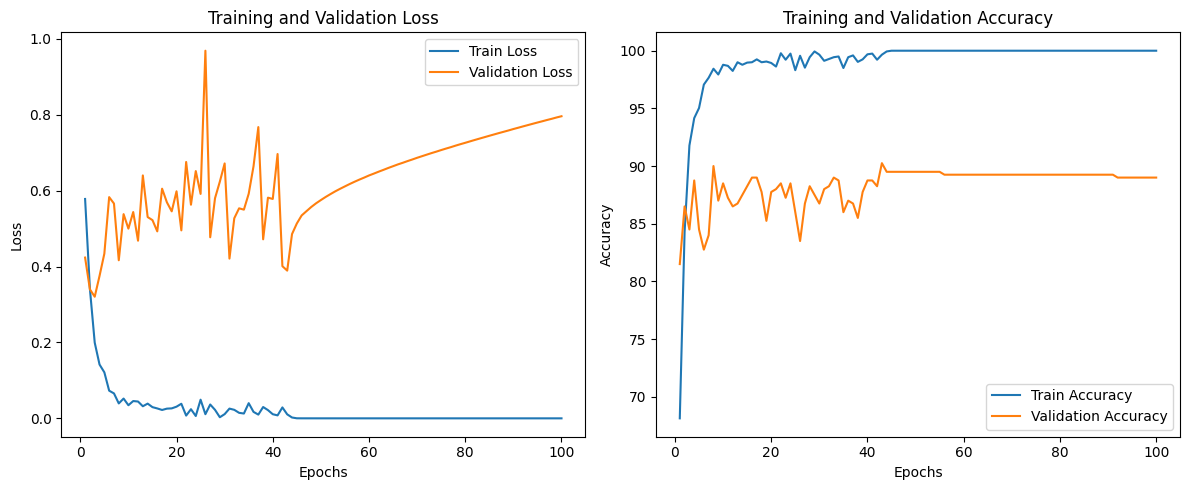

In [505]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss}
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## Pred = 1 if,output > 0.3

In [506]:
f1_score_result, recall_score_result, precision_score_result, all_labels, all_predictions = evaluate(model, test_loader, criterion, device, phase="Test", th=0.3)

Test: 100%|██████████| 13/13 [00:00<00:00, 95.30it/s]

Test Loss: 0.4944, Test Accuracy: 90.00%


In [507]:
print(f"F1 Score: {f1_score_result:.3f}")
print(f"Recall Score: {recall_score_result:.3f}")
print(f"Precision Score: {precision_score_result:.3f}")

F1 Score: 0.882
Recall Score: 0.819
Precision Score: 0.955


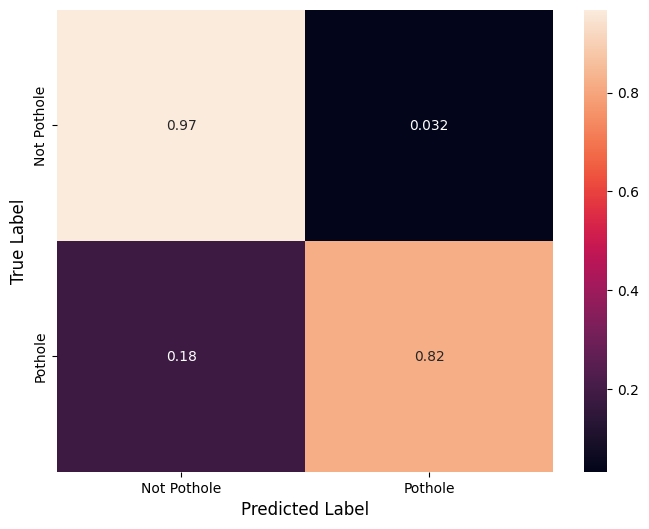

In [508]:
P_NP = ["Not Pothole", "Pothole"]

cf_matrix = confusion_matrix(all_labels, all_predictions)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in P_NP],
                     columns = [i for i in P_NP])

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

plt.show()

In [509]:
print(cf_matrix)

[[211   7]
 [ 33 149]]


## Pred = 1 if,output > 0.5

In [510]:
f1_score_result, recall_score_result, precision_score_result, all_labels, all_predictions = evaluate(model, test_loader, criterion, device, phase="Test", th=0.5)

Test: 100%|██████████| 13/13 [00:00<00:00, 94.78it/s]

Test Loss: 0.4944, Test Accuracy: 89.75%


In [511]:
print(f"F1 Score: {f1_score_result:.3f}")
print(f"Recall Score: {recall_score_result:.3f}")
print(f"Precision Score: {precision_score_result:.3f}")

F1 Score: 0.878
Recall Score: 0.813
Precision Score: 0.955


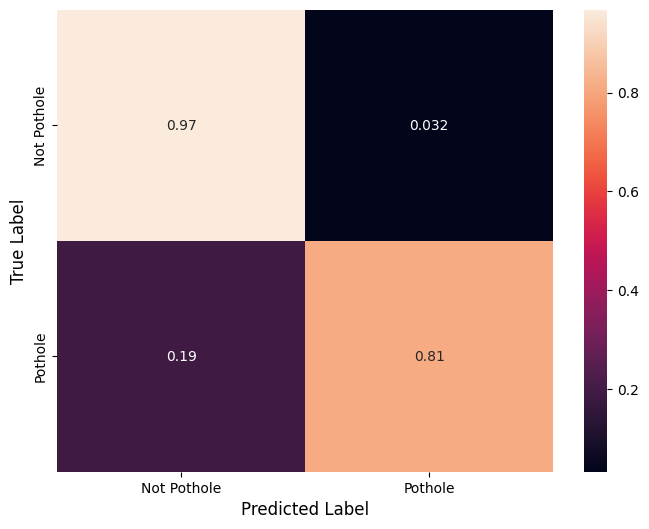

In [512]:
P_NP = ["Not Pothole", "Pothole"]

cf_matrix = confusion_matrix(all_labels, all_predictions)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in P_NP],
                     columns = [i for i in P_NP])

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

plt.show()

In [513]:
print(cf_matrix)

[[211   7]
 [ 34 148]]


## Pred = 1 if,output > 0.7

In [514]:
f1_score_result, recall_score_result, precision_score_result, all_labels, all_predictions = evaluate(model, test_loader, criterion, device, phase="Test", th=0.7)

Test: 100%|██████████| 13/13 [00:00<00:00, 92.15it/s]

Test Loss: 0.4944, Test Accuracy: 89.25%


In [515]:
print(f"F1 Score: {f1_score_result:.3f}")
print(f"Recall Score: {recall_score_result:.3f}")
print(f"Precision Score: {precision_score_result:.3f}")

F1 Score: 0.872
Recall Score: 0.802
Precision Score: 0.954


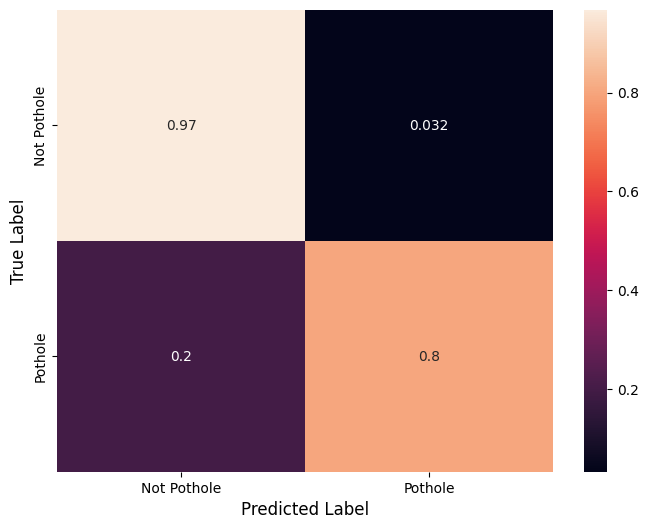

In [516]:
P_NP = ["Not Pothole", "Pothole"]

cf_matrix = confusion_matrix(all_labels, all_predictions)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in P_NP],
                     columns = [i for i in P_NP])

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

plt.show()

In [517]:
print(cf_matrix)

[[211   7]
 [ 36 146]]


In [518]:
from torchsummary import summary

print(summary(model, input_size=(1, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 192, 14, 14]          49,344
          Identity-2             [-1, 196, 192]               0
        PatchEmbed-3             [-1, 196, 192]               0
           Dropout-4             [-1, 197, 192]               0
          Identity-5             [-1, 197, 192]               0
          Identity-6             [-1, 197, 192]               0
         LayerNorm-7             [-1, 197, 192]             384
            Linear-8             [-1, 197, 576]         111,168
          Identity-9           [-1, 3, 197, 64]               0
         Identity-10           [-1, 3, 197, 64]               0
           Linear-11             [-1, 197, 192]          37,056
          Dropout-12             [-1, 197, 192]               0
        Attention-13             [-1, 197, 192]               0
         Identity-14             [-1, 1

In [519]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [520]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 13
Average Time: 7.82 ms
Standard Deviation: 0.35 ms
Maximum Time: 8.24 ms
Minimum Time: 6.66 ms
